Tracking activations and gradients

In [41]:
import ale_py
import shimmy
import gymnasium as gym
import numpy as np
import keyboard
import pickle
import matplotlib.pyplot as plt

In [162]:
lr = 1e-4
discount_factor = 0.95
episodes = 1

In [334]:
class MLP:
    def __init__(self, input_len, hidden_layer):
        self.W1 = np.random.randn(input_len, hidden_layer) / (input_len**0.5) * 5/3
        self.B1 = np.random.randn(hidden_layer) * 0.01
        self.W2 = np.random.randn(hidden_layer, 1) / (hidden_layer**0.5) #* 5/3
        # self.B2 = np.random.randn(1) * 0.01

        self.h = []
        self.h2 = []
        self.temp = []
    def forward(self, x):
        hidden2 = x @ self.W1 + self.B1
        
        hidden = np.tanh(hidden2)
        a = hidden @ self.W2

        self.temp.append(hidden2)
        self.h.append(hidden)
        self.h2.append(a.copy())

        return 1.0 / (1.0 + np.exp(-a)[0].astype(np.float32)) # sigmoid
    
    def backprop(self, x, probs, gradients):
        self.h = np.array(self.h)
        self.h2 = np.array(self.h2)
        
        gradients *= probs * (1-probs) # (batch, 1)
        # self.dB2 = gradients.sum(0) # (batch, 1).sum(0) = (1)
        self.dW2 = self.h.transpose() @ gradients # (200, batch) @ (batch, 1) = (200, 1)
        # self.dW2 /= 5*self.dW2.std()
        gradients = gradients @ self.W2.transpose() * (1-self.h**2)# (batch, 1) @ (1, 200) = (batch, 200)
        self.dB1 = gradients.sum(0) # (batch, 200).sum(0) = (200)
        self.dW1 = x.transpose() @ gradients # (6400, batch) @ (batch, 200)
        # self.dW1 /= 5*self.dW1.std()
        self.W1 -= lr * self.dW1
        self.B1 -= lr * self.dB1
        self.W2 -= lr * self.dW2
        # self.B2 -= lr * self.dB2

    def choose_action(self, observation):
        prob = self.forward(np.array(observation)) # probability of moving down
        if np.random.uniform() > prob:
            return 2, prob # up 
        else:
            return 3, prob # down

    def reset_grad(self):
        # h1 = np.array(self.h)
        # h2 = np.array(self.h2)
        # h3 = np.array(self.temp)
        self.h = []
        self.h2 = []
        self.temp = []

In [328]:
def preprocess(frame):
    # erase everything except ball and paddles
    frame = frame[34:193]
    frame = frame[::2, ::2]
    frame[frame==87] = 0
    frame[frame!=0] = 1

    return np.ravel(frame).astype(np.float32)

def discount_gradients(gradients):
    x = 1.0
    for i in range(len(gradients)-2, -1, -1):
        x *= discount_factor
        gradients[i][0] *= x


In [364]:
env = gym.make("ALE/Pong-v5", obs_type="grayscale")
observation, _ = env.reset()

# policy = MLP(6400, 200)
with open('model.pickle', 'rb') as file:
    policy = pickle.load(file)

episode_number = 0
game_number = 0
frame_number = 0

score = 0
while episode_number < episodes:
    observation = preprocess(np.array(observation))
    if frame_number < 2:
        action = env.action_space.sample()
    else:
        x = observation-prev_observation
        # x -= x.mean()
        # if x.std() != 0.0:
        #     x /= x.std()
        if frame_number == 2 and game_number == 0:
            policy.reset_grad()
            action, y = policy.choose_action(x)
            input = [x]
            output = [[y]]
            actions = [[1.0 if action==2 else -1.0]] # 1 gradient for up, -1 gradient for down
            # actions = [[(1.0 if action==2 else 0)-y]]
        else:
            action, y = policy.choose_action(x)
            input.append(x)
            output.append([y])
            if frame_number == 2:
                actions = [[1.0 if action==2 else -1.0]]
                # actions = [[(1.0 if action==2 else 0)-y]]
            else:
                actions.append([1.0 if action==2 else -1.0])
                # actions.append([(1.0 if action==2 else 0)-y])


    prev_observation = observation
    observation, reward, terminated, truncated, _ = env.step(action)
    frame_number += 1
    
    if reward != 0:
        frame_number = 0
        if game_number == 0:
            gradients = np.array(actions)*reward
            discount_gradients(gradients)
        else:
            temp = np.array(actions)*reward
            discount_gradients(temp)
            gradients = np.vstack((gradients, temp))
        game_number += 1

        if reward == 1:
            score += 1

    if terminated or truncated:
        gradients -= gradients.mean()
        gradients /= gradients.std()
        policy.backprop(np.array(input), np.array(output), gradients)

        observation, _ = env.reset()
        print(f'Episode {episode_number}, Score {score}')
        episode_number += 1
        score = 0
        game_number = 0
env.close()

Episode 0, Score 1


In [362]:
print(policy.B1.max(), policy.B1.min())
print(policy.W1.max(), policy.W1.min())
print(policy.W2.max(), policy.W2.min())
print(policy.B1.mean())
print(policy.W1.mean())
print(policy.W2.mean())

0.02728428189705616 -0.029857684589700454
0.09916244796665824 -0.10049147074110464
0.11635642581361665 -0.11387816246619648
-0.0007872404498533888
1.9159107137136776e-05
-0.0019788094303472997


input mean - 1.6844327547005378e-05, input std - 0.0650051012635231
-0.0007765349091371393 0.10507480356210032
-0.0007746931088441452 0.10365626493765792
-0.00558767590564606 0.052642883754567514
0.4986038 0.013149314


(array([ 0.38974065,  0.38974065,  0.38974065,  0.        ,  0.77948131,
         1.94870327,  0.        ,  1.55896261,  2.33844392,  2.72818457,
         3.11792523,  4.28714719,  3.50766588, 10.9127383 ,  7.01533176,
        13.64092287, 16.7588481 , 19.87677333, 17.14858875, 25.33314248,
        26.11262378, 28.4510677 , 43.26121254, 43.26121254, 43.65095319,
        23.38443921, 25.33314248, 20.26651398, 14.42040418, 15.58962614,
        14.42040418,  8.96403503,  7.79481307,  8.18455372,  7.79481307,
         6.62559111,  4.67688784,  2.33844392,  3.11792523,  0.77948131,
         1.16922196,  0.38974065,  1.16922196,  0.77948131,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.38974065]),
 array([0.45036131, 0.45242552, 0.45448972, 0.45655393, 0.45861814,
        0.46068234, 0.46274655, 0.46481076, 0.46687496, 0.46893917,
        0.47100338, 0.47306758, 0.47513179, 0.477196  , 0.4792602 ,
        0.48132441, 0.48338862, 0.48545282, 0.48751703, 0.489581

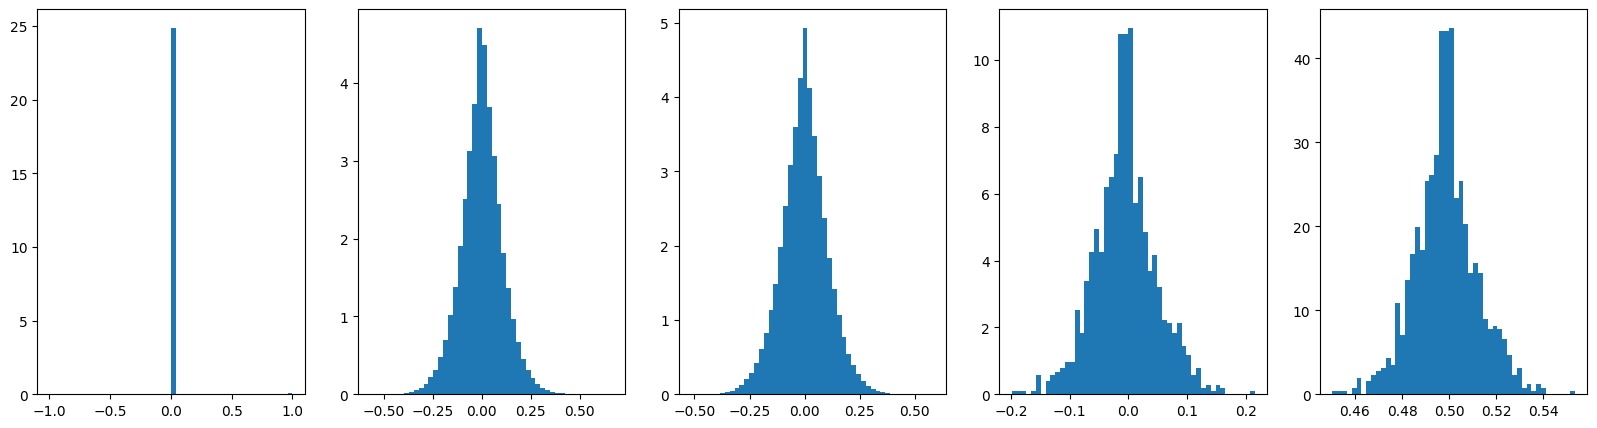

In [365]:

input = np.array(input)
output = np.array(output)
policy.temp = np.array(policy.temp)
policy.h = np.array(policy.h)
policy.h2 = np.array(policy.h2)
print(f'input mean - {input.mean()}, input std - {input.std()}')
print(policy.temp.reshape(-1).mean(), policy.temp.reshape(-1).std())
print(policy.h.reshape(-1).mean(), policy.h.reshape(-1).std())
print(policy.h2.reshape(-1).mean(), policy.h2.reshape(-1).std())
print(output.reshape(-1).mean(), output.reshape(-1).std())

plt.figure(figsize=(20, 5))
plt.subplot(151)
plt.hist(input.reshape(-1).tolist(), 50, density=True)
plt.subplot(152)
plt.hist(policy.temp.reshape(-1).tolist(), 50, density=True)
plt.subplot(153)
plt.hist(policy.h.reshape(-1).tolist(), 50, density=True)
plt.subplot(154)
plt.hist(policy.h2.reshape(-1).tolist(), 50, density=True)
plt.subplot(155)
plt.hist(output.reshape(-1).tolist(), 50, density=True)


0.0017804291227536586
1.9944205731808682


(array([ 1.13228252,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.13228252,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         2.26456503,  0.        ,  0.        ,  1.13228252,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  2.26456503,
         2.26456503,  1.13228252,  2.26456503,  3.39684755,  1.13228252,
         0.        ,  1.13228252,  4.52913006,  4.52913006, 10.19054264,
        11.32282516, 36.23304052, 84.92118871, 14.71967271, 14.71967271,
         4.52913006,  4.52913006,  1.13228252,  1.13228252,  2.26456503,
         1.13228252,  1.13228252,  1.13228252,  1.13228252,  2.26456503,
         1.13228252,  0.        ,  0.        ,  1.13228252,  0.        ,
         0.        ,  0.        ,  0.        ,  1.1

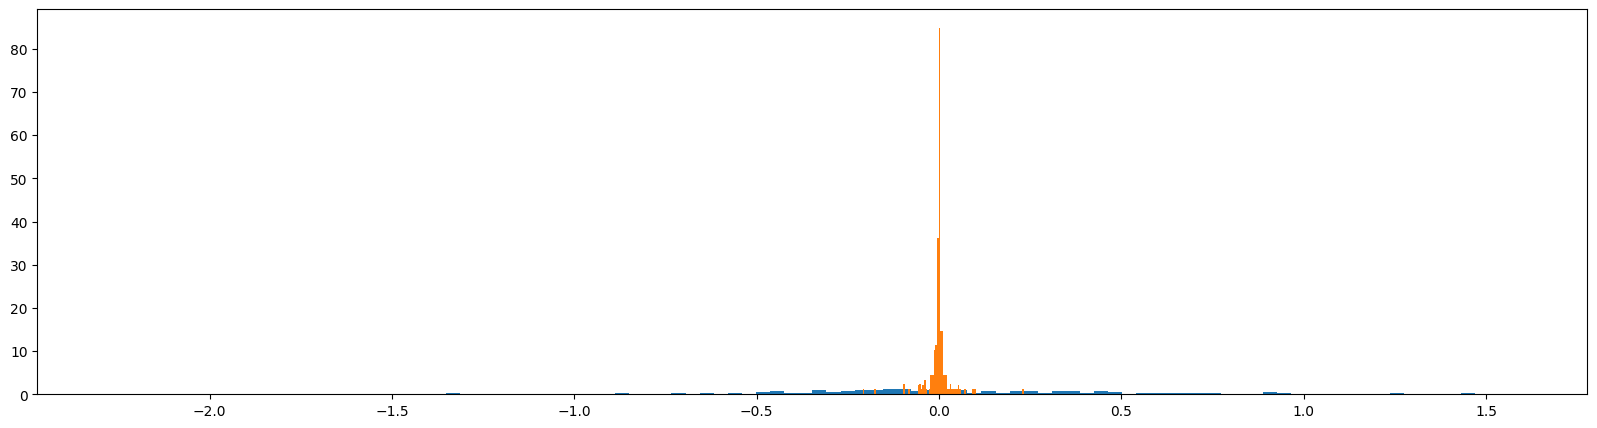

In [ ]:
plt.figure(figsize=(20, 5))
# plt.hist(policy.dB1.reshape(-1).tolist(), 100, density=True)
policy.dW1 /= 2*policy.dW1.std()
print(policy.dW1[abs(policy.dW1)>1e-1].mean())
print(policy.dW1[abs(policy.dW1)>1e-1].std())

plt.hist(policy.dW1[abs(policy.dW1)>1e-1].reshape(-1).tolist(), 50, density=True)
plt.hist(policy.dW2.reshape(-1).tolist(), 100, density=True)
plt.hist(policy.dB1.reshape(-1).tolist(), 100, density=True)
# plt.hist(policy.dB2.reshape(-1).tolist(), 100, density=True)

0.0
0
(964, 200)


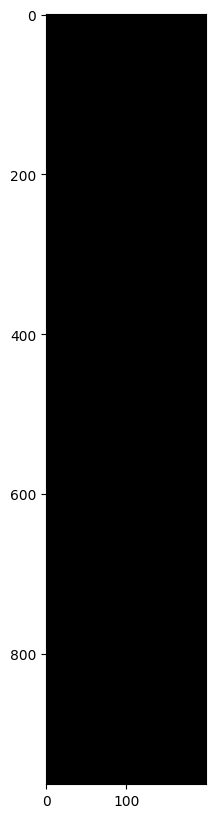

In [339]:
plt.figure(figsize=(20,10))
plt.imshow(np.abs(policy.h) > 0.98, cmap='gray', interpolation='nearest')
print((np.abs(policy.h) > 0.98).sum() / policy.h.size)
print((np.abs(policy.h) > 0.98).sum())
print(policy.h.shape)